In [1]:
## STEP 1 ENVIRONMENT
import numpy as np

class Environment():
  def __init__(self,c_group,n_product,n_arms,a_ratio,p_graph,probability_reward):
    self.c_group=c_group
    self.n_product=n_product
    self.n_arms=n_arms
    self.a_ratio=a_ratio
    self.p_graph=p_graph
    self.probability_reward=probability_reward 

    
  
 
  def round(self,pulled_product,pulled_arm):
    reward=np.random.binomial(1,self.probability_reward[pulled_product,pulled_arm])
    return(reward)

  def connections(self,pulled_product,p_graph,primary):
    click=2
    if np.random.binomial(1,p_graph[pulled_product,primary[0]])==1:
      click=0
      
    elif np.random.binomial(1,p_graph[pulled_product,primary[1]]*0.8)==1:
      click=1
    else:
      click=2
    return click



In [2]:
class Non_Stationary_Environment(Environment):
  def __init__(self,c_group,n_product,n_arms,a_ratio,p_graph,probability_reward,horizon):
    super().__init__(c_group,n_product,n_arms,a_ratio,p_graph,probability_reward)
    self.horizon=horizon
    self.t=0
    n_phases=len(self.probability_reward)
    self.phases_size=horizon/n_phases   

  def round(self,pulled_product,pulled_arm):
    current_phase=int(self.t/self.phases_size)
    p=self.probability_reward[current_phase][pulled_product,pulled_arm]
    reward=np.random.binomial(1,p)
    self.t+=1
    return(reward)
  


In [3]:
import random

def pulled_product( n_product, a_ratio):
  n_product=n_product
  a_ratio=a_ratio

  r = random.randint(1, 99999)/100000
  
  sum_a = 0
  for i in range(n_product+1):
    sum_a = sum_a + a_ratio[i]
    if r <= sum_a:
      #print(r)
      pulledProduct = i
        
      return(pulledProduct)






In [4]:
##STEP 2
class Learner:
  def __init__(self, n_product, n_arms):
    self.n_arms=n_arms
    self.n_product=n_product
    self.t=0
    #self.learning_matrix = learning_matrix

    self.rewards_per_arm = np.empty((n_product, n_arms), dtype=object)
    for i in np.ndindex(self.rewards_per_arm.shape): 
      self.rewards_per_arm[i] = []
    self.collected_rewards=np.array([])


  def update_observations(self,pulled_product,pulled_arm,reward):
    self.rewards_per_arm[pulled_product,pulled_arm].append(reward)
    self.collected_rewards=np.append(self.collected_rewards,reward)

In [5]:
class UCB(Learner):
  def __init__(self, n_product, n_arms):
    super().__init__(n_product,n_arms)
    self.emprical_means=np.zeros((n_product, n_arms),dtype=int)
    self.confidence=np.array([[5000]*n_arms]*n_product,dtype=int)
  
  def learning_matrix(self):
    upper_conf=self.emprical_means+self.confidence    
    #ind = np.argwhere(upper_conf==np.amax(upper_conf,1, keepdims=True))
    #f=list(map(tuple, ind))
    #return np.random.choice(list(zip(*f))[1])
    return(upper_conf)

  
  def update(self,pull_arm,pulled_product,reward):
    self.t+=1
    self.emprical_means[pulled_product,pull_arm]=(self.emprical_means[pulled_product,pull_arm]*(self.t-1)+reward)/self.t
    for a in range(self.n_arms):
      for b in range(self.n_product):
        n_samples=len(self.rewards_per_arm[b,a])
        self.confidence[b,a]=(2*np.log(self.t)/n_samples)**0.5 if n_samples>0 else 5000
    self.update_observations(pulled_product,pull_arm,reward)

In [6]:


class TS_Learner(Learner):
  def __init__(self,n_product,n_arms):
    super().__init__(n_product,n_arms)

    
    self.beta_parameteres=np.ones((n_product,n_arms,2))
    

  def learning_matrix(self,n_product,n_arms):
    globidx2 = []
    for i in range(self.n_product):
      globidx = []
      for j in range(self.n_arms):
        f =np.random.beta(self.beta_parameteres[i,j,0],self.beta_parameteres[i,j,1])
        #idx=np.argmax(f)
        globidx.append(f)
      globidx2.append(globidx)
    return(globidx2)

  def update(self,pull_arm,pulled_product,reward):
    self.t+=1
    self.update_observations(pulled_product,pull_arm,reward)
    self.beta_parameteres[pulled_product,pull_arm,0]=self.beta_parameteres[pulled_product, pull_arm,0]+reward
    self.beta_parameteres[pulled_product, pull_arm,1]=self.beta_parameteres[pulled_product, pull_arm,1]+1.0-reward

  

In [7]:
class SWTS_Learner(TS_Learner):
  def __init__(self,n_arms,n_product,window_size):
    super().__init__(n_arms,n_product)
    self.window_size=window_size
    self.pulled_arms=np.array([])
    self.pulled_products=np.array([])


  def update(self,pulled_arm,pulled_product,reward):
    self.t+=1
    self.update_observations(pulled_arm, pulled_product, reward)
    self.pulled_arms=np.append(self.pulled_arms,pulled_arm)
    self.pulled_products=np.append(self.pulled_products,pulled_product)
    for product in range(self.n_product):
      for arm in range(self.n_arms):
        n_samples=np.sum(self.pulled_arms[-self.window_size:]==arm and self.pulled_products[-self.window_size:]==product)
        cum_rew=np.sum(self.rewards_per_arm[product,arm][-n_samples:]) if n_samples>0 else 0
        self.beta_parameteres[product,arm,0]=cum_rew+1.0
        self.beta_parameteres[product,arm,1]=n_samples-cum_rew+1

In [8]:

import numpy as np
from numpy.core.fromnumeric import argmax

def Greedy(n_product,n_arms,lm):
  n_arms = n_arms
  n_product = n_product
  lm = lm
  initial = np.zeros((n_product,1),dtype=int)
  reward = np.zeros((n_product,1))
  saved_reward = 0

  for k in range(300):
    reward = np.zeros((n_product,1))
    for j in range(n_product):
      if initial[j,0] < n_arms-1:
        initial[j,0] = initial[j,0] + 1
        for i in range(n_product):
          reward[j,0] = reward[j,0] + lm[i,  initial[i,0]]
        initial[j,0] = initial[j,0] - 1
      maxrew = argmax(reward)
        

    if saved_reward < max(reward):
      initial[maxrew,0] = initial[maxrew,0] + 1
      saved_reward = max(reward)
  return(initial)
  


<class 'numpy.ndarray'>
11.299664010580287
3.4003550965187737


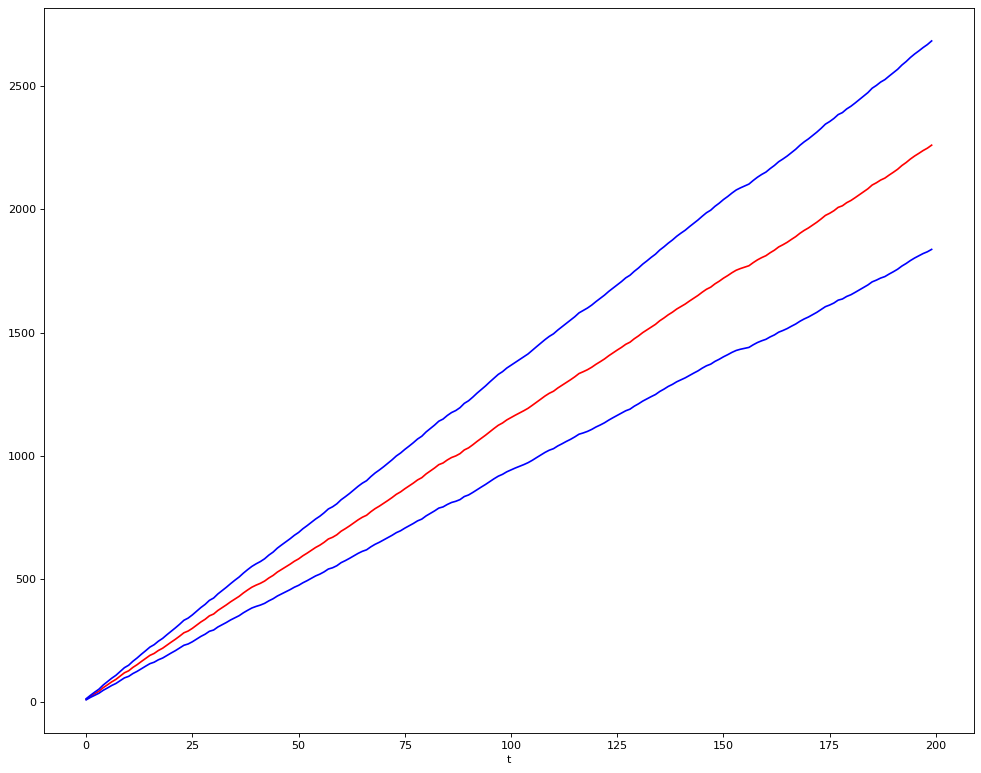

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy.core.fromnumeric import argmax

#from Environment import *
#from TS_Learner import *
#from Greedy_Learner import *
p_graph = ([[0, 0, 0.3, 0.8, 0.1],
       [0.2, 0, 0.45, 0, 0.2],
       [1, 0.2, 0, 0, 0.2],
       [0.3, 0.7, 0, 0, 0],
       [0, 0.2, 0, 0.2, 0.4]])
p_graph = np.asarray(p_graph)

price = ([[5, 10, 15, 20],
       [35, 42, 49, 56],
       [1, 2, 3, 4],
       [22, 25, 28, 30],
       [2, 4, 7, 8]])
price = np.asarray(price)
n_arms = 4
n_products = 5
c_group = 1 
a_ratio = [0.2,0.2,0.2,0.2,0.2]
probability_reward = ([[[0.9, 0.6, 0.3, 0.1],
                          [0.8, 0.7, 0.55, 0.4],
                          [0.6, 0.3, 0.2, 0.1],
                          [0.9, 0.85, 0.7, 0.2],
                          [0.7, 0.3, 0.2, 0.1]],
                      [[0.1, 0.4, 0.1, 0.2],
                          [0.4, 0.3, 0.2, 0.1],
                          [0.7, 0.6, 0.4, 0.2],
                          [0.9, 0.85, 0.7, 0.2],
                          [0.7, 0.3, 0.2, 0.1]],
                      [[0.2, 0.4, 0.3, 0.1],
                          [0.8, 0.7, 0.55, 0.4],
                          [0.6, 0.3, 0.3, 0.1],
                          [0.9, 0.6, 0.7, 0],
                          [0.4, 0.2, 0.2, 0]],
                      [[0, 0, 0, 0],
                          [0, 0, 0, 0],
                          [0, 0, 0, 0],
                          [0.6, 0.5, 0.4, 0.2],
                          [0.7, 0.3, 0.2, 0.1]]])
probability_reward = np.asarray(probability_reward)
#EV = price*probability_reward ---(burayi comente aldim çunku probability matrix degisti error veriyor)
#print(EV)
#opt =[]
#for i in range(n_products):
  #line_max = argmax(EV[i,:])
  #opt.append(line_max)
opt = price[:,3]
opt = [6, 30,  1, 22, 2]
opt = np.asarray(opt)

#print(probability_reward)
#probability_reward = np.random.uniform(low=0.0, high=1.0, size=(5,4))
probability_click = np.random.uniform(low=0.0, high=1.0, size=(5,4))
print(type(probability_click))
#print(probability_click)
probability_click2 = np.random.uniform(low=0.0, high=1.0, size=(5,4))
# prob reward from learner

#p=np.array([0.15,0.1,0.1,0.35])
#opt=p[3]
T=50
n_days=200
horizon = T*n_days
TS_rewards_per_experiment=[]
TS_regret_per_experiment=[]




for e in range(0,n_days):
  learner=Learner(n_product=n_products,n_arms=n_arms)
  ts_learner=TS_Learner(n_product=n_products,n_arms=n_arms)
  ucb_learner=UCB(n_product=n_products,n_arms=n_arms)
  env = Non_Stationary_Environment(c_group=c_group,n_product=n_products,n_arms=n_arms,
                                   a_ratio=a_ratio,p_graph=p_graph,probability_reward=probability_reward,horizon=horizon)
  learning_matrix=ts_learner.learning_matrix(n_products,n_arms)
  learning_matrix = np.asarray(learning_matrix)
  learning_matrix = learning_matrix*price
  pulled_arm = Greedy(n_products,n_arms,learning_matrix)
  
  TS_rewards_per_experiment_Day = []
  TS_regret_per_experiment_Day = []

  for t in range(0,T):
    pulledProduct = pulled_product(n_products,a_ratio)
    if pulledProduct != n_products:
      pulledArm = pulled_arm[pulledProduct,0]
      round = env.round(pulledProduct,pulledArm)
      reward = round
      reward = reward*price[pulledProduct,pulledArm]
      regret = opt[pulledProduct] - reward
      observation_update=learner.update_observations(pulledProduct,pulledArm,reward)
      TS_rewards_per_experiment_Day.append(reward)
      TS_regret_per_experiment_Day.append(regret)
      ts_learner.update(pulledArm,pulledProduct,reward)

      while reward != 0:
        check_matrix = np.ones((n_products),dtype=int)
        for k in range(n_products):
          if(p_graph[pulledProduct,k]==0):
            check_matrix[k] = 0
        check_matrix[pulledProduct] = 0
        
        
        primary = []
        primary = np.asarray(primary,dtype=int)
        idxs1=np.argwhere(check_matrix==check_matrix.max()).reshape(-1)
        primary=np.append(primary,np.random.choice(idxs1))   
        

        check_matrix[primary[0]] = 0
        
        idxs2=np.argwhere(check_matrix==check_matrix.max()).reshape(-1)
        primary=np.append(primary,np.random.choice(idxs2)) 
        check_matrix[primary[0]] = 1
        
          
        click = env.connections(pulledProduct,p_graph,primary)

        if click == 0 or click == 1:
          pulledProduct = primary[click]
          check_matrix[pulledProduct] = 0
          if pulledProduct != n_products:
            pulledArm = pulled_arm[pulledProduct,0]
            round = env.round(pulledProduct,pulledArm)
            reward = round
            reward = reward*price[pulledProduct,pulledArm]
            regret = opt[pulledProduct] - reward
            observation_update=learner.update_observations(pulledProduct,pulledArm,reward)
            TS_rewards_per_experiment_Day.append(reward)
            TS_regret_per_experiment_Day.append(regret)
            ts_learner.update(pulledArm,pulledProduct,reward)

        
  # print(learning_matrix)
  TS_rewards_per_experiment.append(TS_rewards_per_experiment_Day)
  TS_regret_per_experiment.append(TS_regret_per_experiment_Day)


means_reward = []
stds_reward = []
means_reward = np.asarray(means_reward)
stds_reward = np.asarray(stds_reward)

means_regret = []
stds_regret = []
means_regret = np.asarray(means_regret)
stds_regret = np.asarray(stds_regret)

for i in range(n_days):
  mean_reward = np.mean(TS_rewards_per_experiment[i])
  std_reward = np.std(TS_rewards_per_experiment[i])
  mean_regret = np.mean(TS_regret_per_experiment[i])
  std_regret = np.std(TS_regret_per_experiment[i])

  means_reward = np.append(means_reward,mean_reward)
  stds_reward = np.append(stds_reward,std_reward)
  means_regret = np.append(means_regret,mean_regret)
  stds_regret = np.append(stds_regret,std_regret)

meanofallreward = np.mean(means_reward)
meanofallregret = np.mean(means_regret)
print(meanofallreward)
print(meanofallregret)

upper_reward = means_reward+1.96*stds_reward/np.sqrt(n_days)
lower_reward = means_reward-1.96*stds_reward/np.sqrt(n_days)

upper_regret = means_regret+1.96*stds_regret/np.sqrt(n_days)
lower_regret = means_regret-1.96*stds_regret/np.sqrt(n_days)


#mean1=np.mean(TS_regret_per_experiment,axis=1)
#sd = np.std(TS_regret_per_experiment,axis=1)
#upper = mean1+1.96*sd/np.sqrt(n_days)
#lower = mean1-1.96*sd/np.sqrt(n_days)

plt.figure(figsize=(15, 12), dpi=80)
plt.xlabel("t")
#plt.ylabel("Regret")
plt.plot(np.cumsum(means_reward),'r')
plt.plot(np.cumsum(upper_reward),'b')
plt.plot(np.cumsum(lower_reward),'b')
#plt.plot(np.cumsum(np.mean(opt-UCB_rewards_per_experiment,axis=0)),'g')
#plt.legend(["TS","Greedy"])
plt.show()